In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


# Imports

In [ ]:
# Please install any of below dependencies if missing.
import os
import glob
import json
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader

# Domain Adaptation
In image classification, different "domains" refer to different styles or textures of images. When a neural network is trained on a specific domain of images, known as the "source domain", it may perform poorly when tested on a different domain of images, known as the "target domain", due to a phenomenon called **domain shift**. 

*Domain adaptation* techniques aim to address this issue, which is a process called semantic alignment. In domain adaptation, the goal is to ensure that the network cannot differentiate between the distributions of training and test domain examples.

# Data

**Dataset**

In this assignment, we used the **Adaptiope** dataset with the 20 choosen categories from the *product* and *real_world* domains. The choosen categories are included in `target_classes` variable. The original dataset contains 123 object categories, each have around 300 samples equally divided into three domains: ***synthetic***, ***product***, and ***real_world***.

**Train Test Split**

We splitted dataset into trainset and testset with ratio 80%/20%. Splits were performed with each class individualy to balance the ratio of samples within classes. We visualized the number of samples in trainset and validset below.

**Data Transformations**

We apply augmentation with the trainset while keep the testset origin. Images then will be resized to `256` and normalized with mean `[0.485, 0.456, 0.406]` and variance `[0.229, 0.224, 0.225]` as suggested by provided torch_vision pretrained Resnet model.

The details of transformations can be found in `Dataset` class, `self.aug_transform` and `self.torch_transform` variables.

In [ ]:
"""
Instruction for data_path:
In case the availability of Adaptiope dataset folder, the below code can be processed by update the data_path variable with Adaptiope directory 
"""
## This code copy Adaptiope.zip to remote storage, then unzip it to directory ./Adaptiope
# from os import makedirs
# !mkdir dataset
# !cp "/content/drive/MyDrive/Adaptiope.zip" dataset/
# !unzip dataset/Adaptiope.zip

## Update data_path to dataset directory if Adaptiope dataset available
# Path to Adaptiope data folder
data_path = "./Adaptiope/"
assert os.path.isdir(data_path)

# Selected target labels
target_classes = ['backpack', 'bookcase', 'car jack', 'comb', 'crown', 'file cabinet', 'flat iron', 'game controller', 'glasses', 'helicopter', 'ice skates', 'letter tray', 'monitor',
'mug', 'network switch', 'over-ear headphones','pen', 'purse', 'stand mixer', 'stroller']

# Label mapping to align label_idx between datasets
label_mapping = {name:idx for idx, name in enumerate(target_classes)}

## Dataset Observation

Based on the first observation, the main different between **product** images and **real_world** images is the background characteristic. Real_world images have more complicated background than product_images with blank background. Thus the training on real_world dataset is expected to produce more discriminative features than the training on product dataset.

## [code] Dataset class

In [ ]:
class Dataset():
    def __init__(self, list_paths, mapping, is_train=False):
        self.set_train(is_train)

        # Valid_path check
        for path in list_paths:
            assert os.path.isfile(path), path

        # Data storage
        self.data = [{"path": path,
                      "label":path.split("/")[-2],
                      "label_idx": mapping[path.split("/")[-2]]} for path in list_paths if path.split("/")[-2] in mapping]

        # Torch_transform
        self.torch_transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # reference from Res pretrained setting
        ])

        # Augment_transform
        self.aug_transform = A.Compose([
            A.Resize(height=512, width=512),
            A.RandomCrop(width=400, height=400, p=0.7),
            A.Flip(p=0.2),
            A.CoarseDropout(p=0.2, fill_value=127),
            A.ColorJitter(p=0.2),
            A.SafeRotate(p=0.2),
            ])


    def set_train(self, status=True):
        assert status in [True, False], status
        self.is_train = status


    def count_data(self):
        count = {}
        for data in self.data:
            if data["label"] not in count:
                count[data["label"]] = set()
            count[data["label"]].add(data["path"])
        for key, val in count.items():
            count[key] = len(val)
        return dict(sorted(count.items()))

    def __load__(self, idx):
        data = self.data[idx]
        img  = cv.imread(data["path"])
        label_idx = data["label_idx"]
        if self.is_train:
            img = self.aug_transform(image=img)["image"]
        return img, label_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label_idx = self.__load__(idx)
        img_tensor = self.torch_transform(Image.fromarray(img))
        label_tensor = torch.tensor([label_idx], dtype=torch.long).view(-1)
        return img_tensor, label_tensor

## Data Preprocessing

In [ ]:
# List of data_path from Adaptiope folder
data_paths = glob.glob(data_path+"/*/*/*")
data_paths = [path for path in data_paths if path.split("/")[-2] in label_mapping]
realset = [path for path in data_paths if "real" in path.split("/")[-3]]
prodset = [path for path in data_paths if "product" in path.split("/")[-3]]

# Low version of torch random_split dont support ratio divider
def divider(subset, ratio_train=0.8):
    set_length = len(subset)
    num_train = int(set_length*ratio_train)
    num_valid = set_length - num_train
    return [num_train, num_valid]

# train test split with balanced sample ratio within classes (non-duplicated samples)
dataset={"real":{"train":[], "valid":[]}, "prod":{"train":[], "valid":[]}}
for random_seed_idx, cls_name in enumerate(target_classes): # Random seed -> to produce same dataset in different reload
    tmp_real = sorted([path for path in realset if path.split("/")[-2] == cls_name])
    tmp_prod = sorted([path for path in prodset if path.split("/")[-2] == cls_name])
    real_train, real_valid = torch.utils.data.random_split(tmp_real, divider(tmp_real), generator=torch.Generator().manual_seed(random_seed_idx))
    prod_train, prod_valid = torch.utils.data.random_split(tmp_prod, divider(tmp_prod), generator=torch.Generator().manual_seed(random_seed_idx))
    dataset["real"]["train"] += list(real_train)
    dataset["real"]["valid"] += list(real_valid)
    dataset["prod"]["train"] += list(prod_train)
    dataset["prod"]["valid"] += list(prod_valid)
    
# Dataset
dataset_real_train = Dataset(list_paths=dataset["real"]["train"], mapping=label_mapping, is_train=True) # is_train: True/False: apply/not_apply aug_transform on images
dataset_real_valid = Dataset(list_paths=dataset["real"]["valid"], mapping=label_mapping, is_train=False)
dataset_prod_train = Dataset(list_paths=dataset["prod"]["train"], mapping=label_mapping, is_train=True)
dataset_prod_valid = Dataset(list_paths=dataset["prod"]["valid"], mapping=label_mapping, is_train=False)
# train_set, valid_set = torch.utils.data.random_split(dataset, [0.8,0.2]) # doesnt retains attributes of dataset

print("Counting samples in constructed dataset")
print(" ---------------------------------------- ")
print("real_train_count: ", dataset_real_train.count_data(), "\nreal_valid_count:  ", dataset_real_valid.count_data())
print("prod_train_count: ", dataset_prod_train.count_data(), "\nprod_valid_count:  ", dataset_prod_valid.count_data())


Counting samples in constructed dataset
 ---------------------------------------- 
real_train_count:  {'backpack': 80, 'bookcase': 80, 'car jack': 80, 'comb': 80, 'crown': 80, 'file cabinet': 80, 'flat iron': 80, 'game controller': 80, 'glasses': 80, 'helicopter': 80, 'ice skates': 80, 'letter tray': 80, 'monitor': 80, 'mug': 80, 'network switch': 80, 'over-ear headphones': 80, 'pen': 80, 'purse': 80, 'stand mixer': 80, 'stroller': 80} 
real_valid_count:   {'backpack': 20, 'bookcase': 20, 'car jack': 20, 'comb': 20, 'crown': 20, 'file cabinet': 20, 'flat iron': 20, 'game controller': 20, 'glasses': 20, 'helicopter': 20, 'ice skates': 20, 'letter tray': 20, 'monitor': 20, 'mug': 20, 'network switch': 20, 'over-ear headphones': 20, 'pen': 20, 'purse': 20, 'stand mixer': 20, 'stroller': 20}
prod_train_count:  {'backpack': 80, 'bookcase': 80, 'car jack': 80, 'comb': 80, 'crown': 80, 'file cabinet': 80, 'flat iron': 80, 'game controller': 80, 'glasses': 80, 'helicopter': 80, 'ice skates': 8

# Evaluation

Follow the instruction, we used accuracy metric to evaluate our result. The accuracy score measures the model's performance by calculating the ratio of correct predictions (true positives and true negatives) out of all predictions made

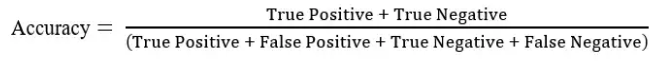

## [code] Evaluator class

In [ ]:
class Evaluator:
    def __init__(self):
        self.eps_loss = 0
        self.num_data, self.num_correct = 0, 0

    def update_acc(self, predict, label):
        predict = predict.detach().cpu().numpy()
        label = label.detach().cpu().numpy()
        classify = np.argmax(predict, axis=-1)
        self.num_data += len(classify)
        self.num_correct += np.sum((label-classify) == 0)

    def update_loss(self, step_loss):
        self.eps_loss += step_loss.item()

    def get_loss(self):
        return self.eps_loss

    def get_acc(self):
        return self.num_correct/self.num_data


# Model

In this section, we provide the models code used in our assignment:

`BaseModel`: contains device attributes to give flexibility in changing tensors to different gpu devices.

`Resnet_backbone`: we provide **baseline_version** and **improved_version** of our features_extractor. The original backbone is Resnet-18 with pretrained weights provided by torch_vision. In **baseline_version**, we only removed the last prediction layer. In **improved_version**, we removed the last prediction layer and add a projection block. This projection layer referenced from [SimCLR.2020](https://arxiv.org/pdf/2002.05709.pdf), which project the extracted global features (from output of last Adaptive Pooling Layer in ResNet backbone) into more relaxed space.

`Resnet`: Classification model with `Resnet_backbone` and a prediction head with 20 classes output.

`Discriminator`: Classification model used in our Unsupervised Domain Adaptation (UDA) method to distinguished real and generate features. 


## [code] Model Classes

In [ ]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.dummy = nn.Parameter(torch.empty(0))

    def device(self):
        return self.dummy.device


class Resnet_backbone(BaseModel):
    def __init__(self, num_class=20, pretrained=False, out_features=1024, is_project=True):
        super(Resnet_backbone, self).__init__()
        backbone = models.resnet18(pretrained=pretrained)
        self.backbone_features = backbone.fc.in_features
        self.is_project = is_project
        if self.is_project:
            self.projection = nn.Sequential(
                    nn.Linear(self.backbone_features, out_features),
                    nn.BatchNorm1d(out_features),
                    nn.ReLU(),
                    nn.Linear(out_features, out_features),
                    nn.BatchNorm1d(out_features)
                )
            self.out_features = out_features 
        else:
            self.out_features = self.backbone_features
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
    
    def forward(self, x):
        feat = self.backbone(x).squeeze()
        if len(feat.size()) == 1:
            feat = feat.unsqueeze(0)
        if self.is_project: feat = self.projection(feat)
        return feat


class Resnet(BaseModel):
    def __init__(self, num_class=20, pretrained=False, freeze_fc=False, project_features=1024, is_project=True):
        super(Resnet, self).__init__()
        self.backbone = Resnet_backbone(num_class, pretrained, project_features, is_project)
        self.backbone_features = self.backbone.out_features

        self.fc = nn.Linear(self.backbone_features, num_class) #resnet50 -> 2048, resnet18 -> 512
        if freeze_fc:
            for name, param in self.fc.named_parameters():
                param.requires_grad = False

    def forward(self, x):
        feat = self.backbone(x)
        cls  = self.fc(feat)
        return cls, feat

  
class Discriminator(BaseModel):
    def __init__(self, in_channel, num_features=512):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
                    nn.Linear(in_channel, num_features),
                    nn.BatchNorm1d(num_features),
                    nn.ReLU(),
                    nn.Linear(num_features, num_features),
                    nn.BatchNorm1d(num_features),
                    nn.ReLU(),
                    nn.Linear(num_features,1)
                )

    def forward(self, x):
        return self.model(x)

# Loss

In this assignment, we use two following loss:
- Cross-Entropy Loss
- Supervised Contrastive Loss

**Cross Entropy Loss**

Cross-entropy loss is a measure used in training a model to adjust the weights. The goal is to minimize the cross-entropy, which indicates how well the model is performing. A model with a cross-entropy loss of 0 is considered perfect. In the case of having only two classes, Cross-entropy can be called as Binary cross-entropy.

**Supervised Contrastive Loss** 

The supervised contrastive loss [[SupCon.2021](https://arxiv.org/pdf/2004.11362.pdf)] combines these supervised and contrastive learning approaches by using a labeled dataset. The goal of this loss is to minimize the similarity between features from the same classes and minimize the the similarity between the features from the different classes.

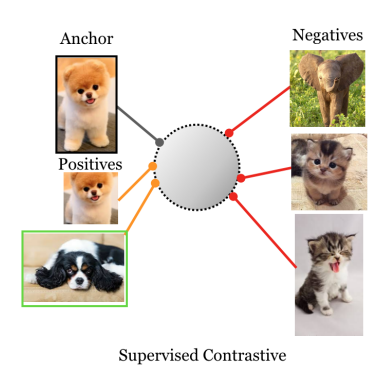

## [code] Implementation of Supervised Contrastive Loss

We borrow the implementation of **Supervised Contrastive Loss** from this [github](https://github.com/HobbitLong/SupContrast) with **small adjustment** to **avoid nan loss function** when one training sample in batch have no positive pairs.

In [ ]:
class SupConLoss(torch.nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    From: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, temperature, contrast_mode='all'):
        super(SupConLoss, self).__init__()
        self.contrast_mode = contrast_mode
        self.temperature = temperature

    def forward(self, features, device="cpu", labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1) # requires 1 labels for each 2 features
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)

        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mask_sum = mask.sum(1)
        mask_sum[mask_sum==0] += 1
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_sum
#         assert torch.sum(mean_log_prob_pos[mask_sum==0]).item() == 0
#         assert not torch.isnan((mask * log_prob).sum())
        loss = - mean_log_prob_pos
#         assert not torch.isnan(mean_log_prob_pos.sum())
        loss = loss.view(anchor_count, batch_size).mean()
#         assert not torch.isnan(loss), mask_sum
        return loss


class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=1):
        super(ContrastiveLoss, self).__init__()
        self.loss = SupConLoss(temperature)
        
    def forward(self, features, labels, device):
        """
        features: (batch, features_num)
        """
        features = F.normalize(features, dim=1)
        return self.loss(features.unsqueeze(1), device, labels=labels.unsqueeze(-1))
#         features = F.normalize(features, dim=1)
#         features_sim = torch.matmul(features, features.T)
        
#         mask_same = torch.eye(features_sim.size(0), dtype=torch.bool)
#         features_sim = features_sim[~mask_same].view(features_sim.size(0), -1)
#         label_mask = label_mask[~mask_same].view(label_mask.size(0), -1)
        
        
#         # Positive similarity is the first columns
#         # Negative similarity are other columns -> labels = 0
#         print(label_mask)
#         pos_pair = features_sim[label_mask.bool()].view(label_mask.size(0), -1)
#         neg_pair = features_sim[~label_mask.bool()].view(features_sim.size(0), -1)
#         print(pos_pair.size(), neg_pair.size())
#         logits = torch.cat([pos_pair, neg_pair], dim=1)
#         labels = torch.zeros(logits.size(0), dtype=torch.long)
#         logits = logits/self.temperature
        
#         loss = self.loss(logits, labels.to(device))
#         return loss

# Trainer

This class contains loss instances and our training functions:

`epoch_train_cls`: epoch to supervised trainning for classification task.

`epoch_train_uda`: epoch to train unsupervised domain adaptation (UDA). We use ADDA method as our UDA approach. The tranning conducted in adversial manner, where the target_cnn is trained to produce same features on target_dataset as source_cnn features produced on source_dataset.

`epoch_eval`: measure the accuracy on provided dataset 



## [code] Trainer class

In [ ]:
class Trainer: # contains functions for training (instance: trainer)
    def __init__(self,):
        self.ce_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)
        self.con_loss = ContrastiveLoss(1)
        self.bce_loss = torch.nn.BCEWithLogitsLoss(reduction="mean")

    def epoch_train_cls(self, model, optim, dataloader, w_ce, w_con):
        evaluator = Evaluator()
        model.train()
        for data, label in dataloader:
            """
            - Data: (b, c, h, w)
            - Label: (b, 1) # index
            - Predict: (b, num_class)
            """
            data = data.to(model.device())
            label = label.to(model.device()).view(-1)
            predict, features = model(data)
            ce_loss = self.ce_loss(predict, label)
            con_loss = self.con_loss(features, label, model.device())
            step_loss = w_ce*ce_loss + w_con*con_loss
            optim.zero_grad()
            step_loss.backward()
            optim.step()

            evaluator.update_loss(step_loss)
            evaluator.update_acc(predict, label)
        return evaluator.get_loss(), evaluator.get_acc()


    def epoch_train_uda(self, model_s, model_t, model_d, optim_t, optim_d, loader_src, loader_trg):
        evaluator_D_src = Evaluator()
        evaluator_D_trg = Evaluator()
        evaluator_T = Evaluator()
        model_t.train()
        model_d.train()
        model_s.eval() # BN change with new dataset
        device = model_s.device()

        dataloader = zip(loader_src, loader_trg)
        for ((data_src, _), (data_trg, _)) in dataloader:
            data_src, data_trg = data_src.to(device), data_trg.to(device)

            # Update D
            with torch.no_grad():
                _, feat_src = model_s(data_src)
                _, feat_trg = model_t(data_trg)
            cls_src = model_d(feat_src)
            cls_trg = model_d(feat_trg)

            lab_src = torch.ones(cls_src.size(), requires_grad=False).to(device)   
            lab_trg = torch.zeros(cls_trg.size(), requires_grad=False).to(device)
            loss_src = self.bce_loss(cls_src, lab_src)
            loss_trg = self.bce_loss(cls_trg, lab_trg)

            loss_d = loss_src + loss_trg
            optim_d.zero_grad()
            loss_d.backward()
            optim_d.step()

            # Update T
            _, feat_trg = model_t(data_trg)
            cls_trg = model_d(feat_trg)
            loss_t = self.bce_loss(cls_trg, 1-lab_trg)
            optim_t.zero_grad()
            loss_t.backward()
            optim_t.step()

            evaluator_D_trg.update_loss(loss_trg)
            evaluator_D_src.update_loss(loss_src)
            evaluator_T.update_loss(loss_t)
        return [evaluator_D_trg.get_loss(), evaluator_D_src.get_loss()], evaluator_T.get_loss()


    @staticmethod
    def epoch_eval(model, dataloader, return_detail=False):
        evaluator = Evaluator()
        model.eval()
        with torch.no_grad():
            predicts_list, label_list, features_list = [], [], []
            for data, label in dataloader:
                data = data.to(model.device())
                label = label.to(model.device()).view(-1)
                predict, features = model(data)
                evaluator.update_acc(predict, label)
                if return_detail:
                    label_list += label.cpu().numpy().flatten().tolist()
                    predicts_list += np.argmax(predict.cpu().numpy(),1).tolist()
                    features_list.append(features.cpu().numpy())
        if not return_detail:
            return evaluator.get_acc()
        else:
            features_list = np.concatenate(features_list, axis=0)            
            return evaluator.get_acc(), label_list, predicts_list, features_list


    def visualize_cnf_tSNE(self, model_path, dataset):
        dataloader = DataLoader(dataset, shuffle=False, batch_size=16, num_workers=2)
        is_project=False if "_baseline" in model_path else True
        model_trg = Resnet(20, pretrained=False, freeze_fc=True, is_project=is_project)
        model_trg.load_state_dict(torch.load(model_path, map_location="cpu"))
        acc_valid, labels, preds, features = self.epoch_eval(model_trg, dataloader, return_detail=True)

        # Visualize confusion matrix
        mtx = confusion_matrix(preds, labels)
        sns.heatmap(mtx, annot=True)
        plt.title("Confusion matrix on target test set of %s"%model_path)
        plt.show()
        
        # Visualize TSNE
        from sklearn.manifold import TSNE
        z = TSNE(n_components=2, init='pca', metric="cosine",square_distances=True).fit_transform(features)
        df = pd.DataFrame()
        df["target"] = labels
        df["dim_0"] = z[:,0]
        df["dim_1"] = z[:,1]
        pallete = sns.color_palette("hls", len(df.target.unique()))
        sns.scatterplot(x="dim_0", y="dim_1", hue="target", palette=pallete, data=df, legend=False)
        plt.show()
        
        
    
    @staticmethod
    def save_model(model, name):
        torch.save(model.state_dict(), name)
        return True

    @staticmethod
    def init_weights(m):
        try:
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
            elif isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)
                # elif isinstance(m, nn.BatchNorm2d):
            else:
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)
        except:
            pass
        
trainer = Trainer()

# Training Loop

## Training Procedure

In this assignment we will conduct two training process:
- Supervised training: train the source model and evaluate the model performance on target dataset. This create the baseline to evaluate the performance of UDA method. Since the target dataset is not available, we will select the source model based on the best possible validation accuracy on source_validset. We conducts this training for both baseline and improved architecture, in two independent experiments:
  - Train on **P_train**, validate on **P_test** and test on **RW_test**
  - Train on **RW_train**, validate on **RW_test** and test on **P_test**
- UDA training: improve the target_cnn model using training dataset without assess to any labels. The training will be conducted in two independent experiments:
  - Baseline model from **P_train**, train on **P_train and RW_train**, test on **RW_test**
  - Baseline model from **RW_train**, train on **P_train and RW_train**, test on **P_test**


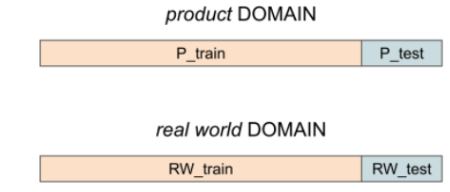

## Hyper parameters

**Batch Size**

A hyperparameter that determines the number of samples processed for one training calculation. Since we are using Contrastive Loss, the batch_size should be large to produce more positive and negative pairs which benefits the loss function. In this project we choose the batch size as 200 (due to limitation of Colab GPU).

**Optimizer SGD** *(with Nesterov Momentum)*

Stochastic gradient descent is a technique used to optimize an objective function through repeated iterations. It approximates the process of gradient descent optimization by using a randomly selected subset of the data to calculate an estimate of the gradient, rather than the full dataset. This approach allows for faster iterations, but may result in a lower convergence rate. It is particularly useful in high-dimensional optimization problems as it reduces the computational burden.

Nesterov Momentum is a variant of the gradient descent optimization algorithm that uses the partial derivative of the projected update rather than the derivative of the current variable value when performing updates. This modification helps to harness the acceleration benefits of momentum while also allowing the search to slow down as it approaches the optima, reducing the risk of overshooting or missing it.



**Learning Rate** : To minimize error, the optimization algorithm must make small adjustments, called steps, as it moves down the error mountain. Each step has a direction and a size, which is determined by the learning rate. A higher learning rate allows the algorithm to make larger steps while a lower learning rate results in smaller steps being taken. These steps are necessary in order to effectively navigate the error curve and reach the lowest point possible. We set the learning rate values as 0.001

**Weight Decay**

The weight_decay parameter adds a L2 penalty to the cost, which can result in smaller model weights and improved generalization. Weight regularization is a technique used to improve the performance of deep learning neural network models by preventing them from overfitting on the training data. This is achieved by adding L2 regularization to the loss function, which reduces the value of each weight during the optimization process. The value of 1e-3 was chosen simply because it is a commonly used, rounded number.

## Supervised Training

In this section, we will perform the supervised learning independently and compare the result between baseline setting and improved setting. 

In [ ]:
# Hyper parameters
cfg_cls = {"num_class":20, "batch_size": 200, "num_workers":2, "pretrained":True, "lr": 0.001, "num_eps":50}

def train_cls(src_train, src_valid, trg_valid, cfg_cls, is_project, w_ce, w_con, name):
    trainer = Trainer()
    # Dataloader
    src_train = DataLoader(src_train, batch_size=cfg_cls["batch_size"], shuffle=True, num_workers=cfg_cls["num_workers"])
    src_valid = DataLoader(src_valid, batch_size=cfg_cls["batch_size"], shuffle=True, num_workers=cfg_cls["num_workers"])
    trg_valid = DataLoader(trg_valid, batch_size=cfg_cls["batch_size"], shuffle=False,num_workers=cfg_cls["num_workers"])

    
    # Model
    model_src = Resnet(cfg_cls["num_class"], pretrained=cfg_cls["pretrained"], freeze_fc=False, is_project=is_project)

    if not cfg_cls["pretrained"]: model_src.apply(trainer.init_weights) # Initialize weight if not pretrained
    if torch.cuda.is_available(): model_src = model_src.cuda() # device

    # Optim
    optim_src = torch.optim.SGD(model_src.parameters(), lr=cfg_cls["lr"], weight_decay=1e-3, momentum=0.9, nesterov=True)

    # Training Loop
    log, best_valid = [], -1
    for eps in range(cfg_cls["num_eps"]):
        loss_train, acc_train = trainer.epoch_train_cls(model_src, optim_src, src_train, w_ce, w_con)
        acc_valid = trainer.epoch_eval(model_src, src_valid)
        acc_test = trainer.epoch_eval(model_src, trg_valid)

        dict_out = {"eps":eps, "train":{"loss":loss_train,"acc":acc_train}, "valid_acc":acc_valid, "test_acc":acc_test}
        print(dict_out)
        log.append(dict_out)
        json.dump(log, open("log_cls_%s.log"%name,"w"))
        if acc_valid > best_valid:
            best_valid = acc_valid
            trainer.save_model(model_src, "model_cls_%s.pth"%name)
            print(" ============ NEW BEST ============ ")
    del model_src

### Supervised learning: Product to Real_World

#### Baseline

In [ ]:
train_cls(
    src_train=dataset_prod_train,
    src_valid=dataset_prod_valid,
    trg_valid=dataset_real_valid,
    cfg_cls=cfg_cls,
    is_project=False,
    w_ce=1.5,
    w_con=0,
    name="PRw_baseline")

{'eps': 0, 'train': {'loss': 36.62799263000488, 'acc': 0.079375}, 'valid_acc': 0.1175, 'test_acc': 0.0775}
 ============ NEW BEST ============ 
{'eps': 1, 'train': {'loss': 31.086607456207275, 'acc': 0.294375}, 'valid_acc': 0.525, 'test_acc': 0.2375}
 ============ NEW BEST ============ 
{'eps': 2, 'train': {'loss': 24.898605823516846, 'acc': 0.61875}, 'valid_acc': 0.8, 'test_acc': 0.4375}
 ============ NEW BEST ============ 
{'eps': 3, 'train': {'loss': 19.194406032562256, 'acc': 0.80125}, 'valid_acc': 0.8925, 'test_acc': 0.54}
 ============ NEW BEST ============ 
{'eps': 4, 'train': {'loss': 14.756186842918396, 'acc': 0.85375}, 'valid_acc': 0.915, 'test_acc': 0.575}
 ============ NEW BEST ============ 
{'eps': 5, 'train': {'loss': 11.486881494522095, 'acc': 0.889375}, 'valid_acc': 0.9225, 'test_acc': 0.59}
 ============ NEW BEST ============ 
{'eps': 6, 'train': {'loss': 9.12113344669342, 'acc': 0.911875}, 'valid_acc': 0.9325, 'test_acc': 0.585}
 ============ NEW BEST ============ 
{'

#### Improved

In [ ]:
train_cls(
    src_train=dataset_prod_train,
    src_valid=dataset_prod_valid,
    trg_valid=dataset_real_valid,
    cfg_cls=cfg_cls,
    is_project=True,
    w_ce=1.5,
    w_con=0.5,
    name="PRw_improved")

{'eps': 0, 'train': {'loss': 47.16373014450073, 'acc': 0.160625}, 'valid_acc': 0.5725, 'test_acc': 0.2825}
 ============ NEW BEST ============ 
{'eps': 1, 'train': {'loss': 34.99887251853943, 'acc': 0.68875}, 'valid_acc': 0.8925, 'test_acc': 0.59}
 ============ NEW BEST ============ 
{'eps': 2, 'train': {'loss': 26.604625463485718, 'acc': 0.86125}, 'valid_acc': 0.9425, 'test_acc': 0.6675}
 ============ NEW BEST ============ 
{'eps': 3, 'train': {'loss': 23.027995109558105, 'acc': 0.90375}, 'valid_acc': 0.9475, 'test_acc': 0.6875}
 ============ NEW BEST ============ 
{'eps': 4, 'train': {'loss': 21.53392004966736, 'acc': 0.9275}, 'valid_acc': 0.955, 'test_acc': 0.69}
 ============ NEW BEST ============ 
{'eps': 5, 'train': {'loss': 20.599838733673096, 'acc': 0.9375}, 'valid_acc': 0.96, 'test_acc': 0.695}
 ============ NEW BEST ============ 
{'eps': 6, 'train': {'loss': 20.077322721481323, 'acc': 0.949375}, 'valid_acc': 0.96, 'test_acc': 0.715}
{'eps': 7, 'train': {'loss': 19.85055541992

### Supervised learning: Real_World to Product

#### Baseline

In [ ]:
train_cls(
    src_train=dataset_real_train,
    src_valid=dataset_real_valid,
    trg_valid=dataset_prod_valid,
    cfg_cls=cfg_cls,
    is_project=False,
    w_ce=1.5,
    w_con=0,
    name="RwP_baseline")

{'eps': 0, 'train': {'loss': 22.072471618652344, 'acc': 0.0675}, 'valid_acc': 0.09, 'test_acc': 0.135}
 ============ NEW BEST ============ 
{'eps': 1, 'train': {'loss': 20.241326332092285, 'acc': 0.123125}, 'valid_acc': 0.19, 'test_acc': 0.195}
 ============ NEW BEST ============ 
{'eps': 2, 'train': {'loss': 18.821341276168823, 'acc': 0.203125}, 'valid_acc': 0.2975, 'test_acc': 0.325}
 ============ NEW BEST ============ 
{'eps': 3, 'train': {'loss': 17.279478311538696, 'acc': 0.353125}, 'valid_acc': 0.4475, 'test_acc': 0.455}
 ============ NEW BEST ============ 
{'eps': 4, 'train': {'loss': 15.824060916900635, 'acc': 0.515}, 'valid_acc': 0.5775, 'test_acc': 0.5825}
 ============ NEW BEST ============ 
{'eps': 5, 'train': {'loss': 14.437816381454468, 'acc': 0.584375}, 'valid_acc': 0.65, 'test_acc': 0.6525}
 ============ NEW BEST ============ 
{'eps': 6, 'train': {'loss': 12.993066906929016, 'acc': 0.66375}, 'valid_acc': 0.7075, 'test_acc': 0.7025}
 ============ NEW BEST ============ 
{

#### Improved

In [ ]:
train_cls(
    src_train=dataset_real_train,
    src_valid=dataset_real_valid,
    trg_valid=dataset_prod_valid,
    cfg_cls=cfg_cls,
    is_project=True,
    w_ce=1.5,
    w_con=0,
    name="RwP_improved")

{'eps': 0, 'train': {'loss': 47.59300231933594, 'acc': 0.14}, 'valid_acc': 0.2975, 'test_acc': 0.3175}
 ============ NEW BEST ============ 
{'eps': 1, 'train': {'loss': 39.21332359313965, 'acc': 0.490625}, 'valid_acc': 0.6625, 'test_acc': 0.715}
 ============ NEW BEST ============ 
{'eps': 2, 'train': {'loss': 31.777637481689453, 'acc': 0.7225}, 'valid_acc': 0.775, 'test_acc': 0.84}
 ============ NEW BEST ============ 
{'eps': 3, 'train': {'loss': 27.68445897102356, 'acc': 0.80125}, 'valid_acc': 0.825, 'test_acc': 0.8725}
 ============ NEW BEST ============ 
{'eps': 4, 'train': {'loss': 24.859858989715576, 'acc': 0.865}, 'valid_acc': 0.86, 'test_acc': 0.8775}
 ============ NEW BEST ============ 
{'eps': 5, 'train': {'loss': 23.550768613815308, 'acc': 0.875}, 'valid_acc': 0.8575, 'test_acc': 0.8825}
{'eps': 6, 'train': {'loss': 22.582353591918945, 'acc': 0.89875}, 'valid_acc': 0.875, 'test_acc': 0.8925}
 ============ NEW BEST ============ 
{'eps': 7, 'train': {'loss': 22.24640703201294,

### Discussion for Supervised Training

In [ ]:
def visualize_cls(baseline_cls, improved_cls):
    """
    baseline_cls: log of supervised training: [train, valid, test] on [src_train, src_test, trg_test]
    improved_cls: log of supervised training: [train, valid, test] on [src_train, src_test, trg_test]
    """
    baseline_cls = pd.DataFrame(json.load(open(baseline_cls)))
    improved_cls = pd.DataFrame(json.load(open(improved_cls)))
    df = [
        {"src_test":baseline_cls["valid_acc"].max(), "trg_test":baseline_cls["test_acc"].max()},
        {"src_test":improved_cls["valid_acc"].max(), "trg_test":improved_cls["test_acc"].max()}   
    ]
    df = pd.DataFrame(df)  
    df.index = ["baseline", "improved"]

    print("\nVisualization of Learning Curve:")
    sns.lineplot(data=baseline_cls, x="eps", y="test_acc", label="validation_of_baseline_on_trg_testset", color="red", linewidth=1)
    sns.lineplot(data=improved_cls, x="eps", y="test_acc", label="validation_of_improved_on_trg_testset", color="blue", linewidth=1)

    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.show()

    print("Result between baseline and improved setting:\n")
    print(df)

#### Product to Real_world

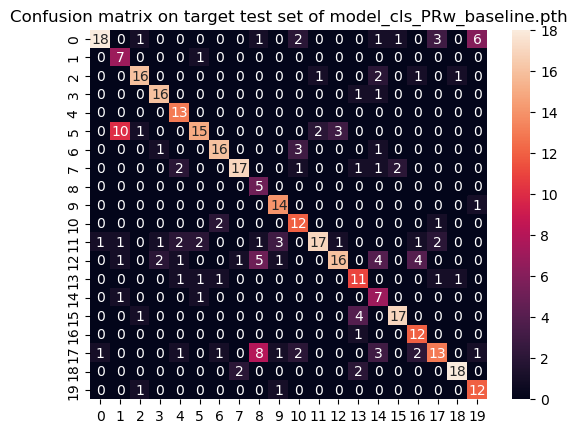

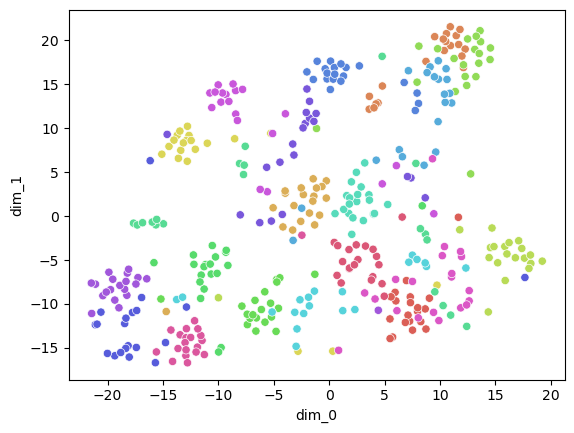

In [ ]:
trainer.visualize_cnf_tSNE("model_cls_PRw_baseline.pth", dataset_real_valid)

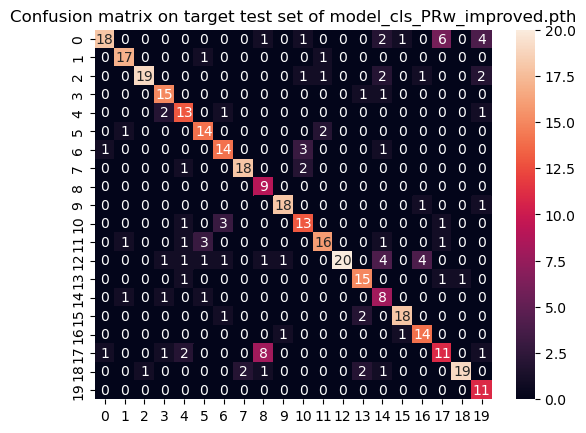

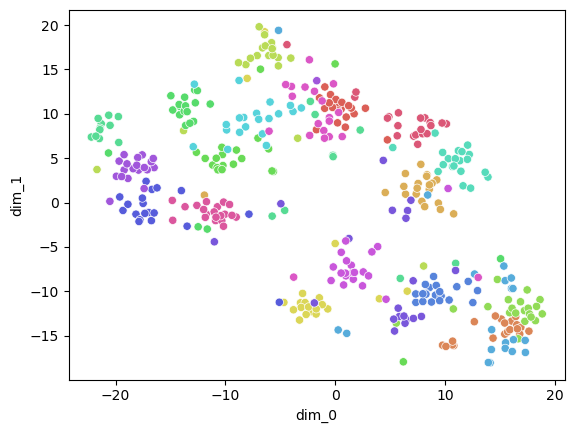

In [ ]:
trainer.visualize_cnf_tSNE("model_cls_PRw_improved.pth", dataset_real_valid)


Visualization of Learning Curve:


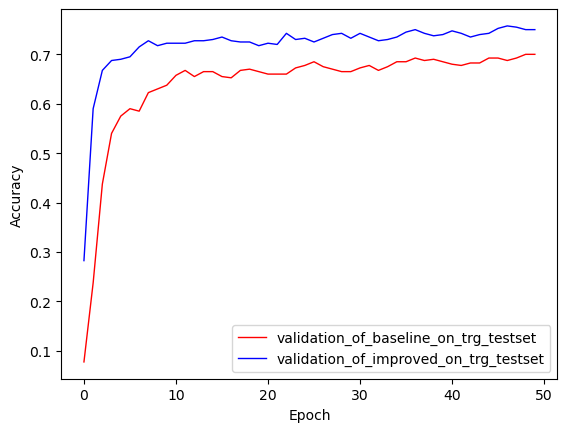

Result between baseline and improved setting:

          src_test  trg_test
baseline    0.9775    0.7000
improved    0.9800    0.7575


In [ ]:
visualize_cls("log_cls_PRw_baseline.log", "log_cls_PRw_improved.log")

In [ ]:
target_classes[8]

'glasses'

**Conclusion**
- The test result of **improved** model setting on RW_test is **0.757**, **higher** than **baseline** model setting with **0.700**.
- The **testing result of class `glasses` (index 8) is bad**. This might because the product images of glasses have clear edges between glasses with blank background, thus causing too easy for features extractor to learn this class in product dataset and lack of generalized discriminative features.
- The representation features of improved model setting have a bit more compact than baseline model setting

#### Real_world to Product

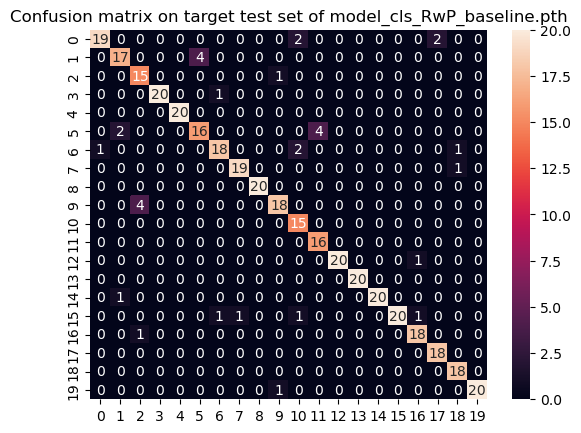

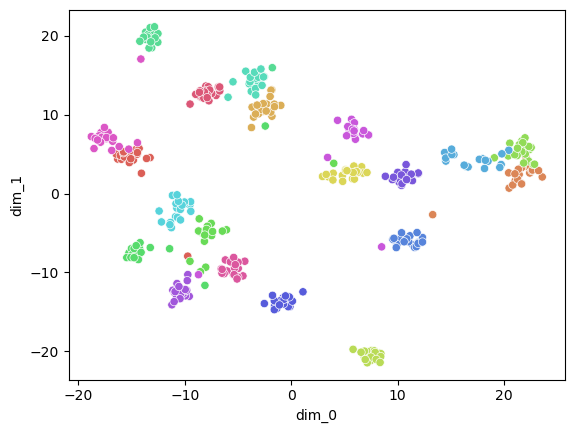

In [ ]:
trainer.visualize_cnf_tSNE("model_cls_RwP_baseline.pth", dataset_prod_valid)

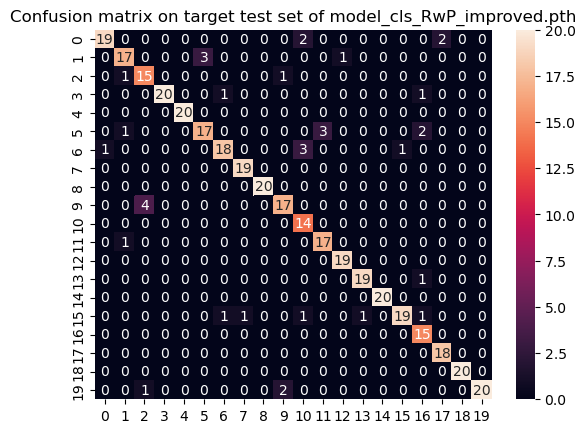

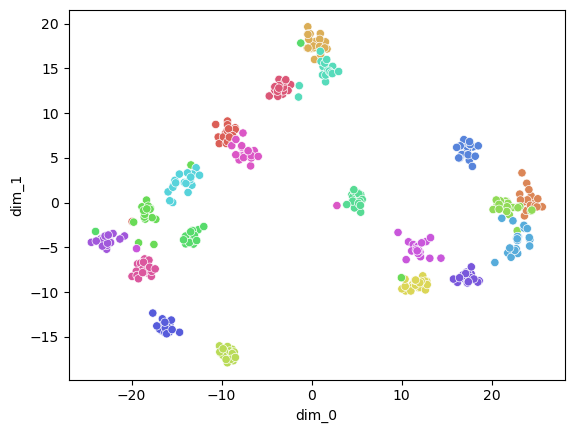

In [ ]:
trainer.visualize_cnf_tSNE("model_cls_RwP_improved.pth", dataset_prod_valid)


Visualization of Learning Curve:


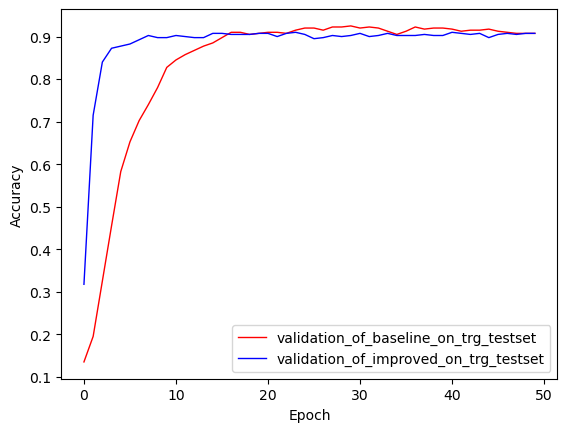

Result between baseline and improved setting:

          src_test  trg_test
baseline    0.9075     0.925
improved    0.9300     0.910


In [ ]:
visualize_cls("log_cls_RwP_baseline.log", "log_cls_RwP_improved.log")

**Conclusion**
- The test result have small gap on P_test between improved setting (0.910) and baseline setting (0.925).
- Compared to the training on P_train, the training on RW_train have a better performance

## Unsupervised Domain Adaptation

### Adversarial Discriminative Domain Adaptation

We apply an unsupervised domain adaptation technique that involves adversarial learning and the learning of distinguishing features. Adversarial adaptive methods involve minimizing a domain discrepancy distance through an adversarial objective with respect to a domain discriminator, which is similar to generative adversarial learning. The Adversarial Discriminative Domain Adaptation (**ADDA**) aims to reduce the difference between the source and target domain distributions in order to improve generalization performance.

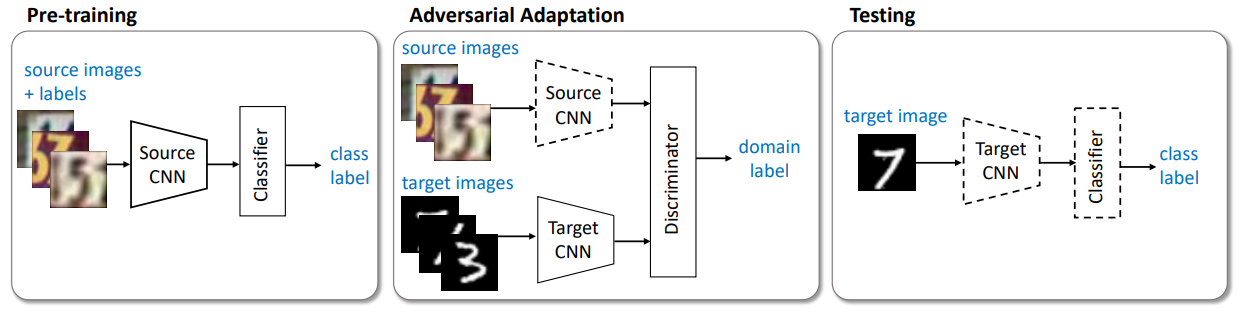

####How it works?
The ADDA paper [[Tzeng.2017](https://arxiv.org/abs/1702.05464)] proposes using two separate encoders for *mapping* images from the source and target domains. Since the **Classifier** is impossible to train without labels of the target data, author propose to train a target encoder that produce a similar features from target dataset. This training is guided by a domain discriminator that is trying to distinguish encoded target features from source features.

**Source encoder** and **Classifier** are frozen during the training.

**Target encoder** has the same architecture as the source encoder and tries to create similar features to source encoder from target dataset.

**Discriminator** distinguish the target features and source features.


ADDA, involves learning a discriminative representation using labels in the source domain and a separate encoding that maps the target data to the same space using an asymmetric, which is more flexible, allowing for more domain-specific feature extraction to be learned by not sharing weights.

In [ ]:
# Hyper parameters
cfg_uda = {"num_class":20, "batch_size":32, "num_workers":2, "num_eps":10}

def train_uda(src_train, trg_train, trg_valid, cfg_uda, name):
    trainer = Trainer()
    
    # Dataloader
    src_train = DataLoader(src_train, batch_size=cfg_uda["batch_size"], shuffle=True, num_workers=cfg_uda["num_workers"])
    trg_train = DataLoader(trg_train, batch_size=cfg_uda["batch_size"], shuffle=True, num_workers=cfg_uda["num_workers"])
    trg_valid = DataLoader(trg_valid, batch_size=cfg_uda["batch_size"], shuffle=False,num_workers=cfg_uda["num_workers"])
    
    # Model
    ckpt = "model_cls_%s_improved.pth"%name
    model_src = Resnet(cfg_uda["num_class"], pretrained=False, freeze_fc=False)
    model_src.load_state_dict(torch.load(ckpt, map_location="cpu"))
    model_trg = Resnet(cfg_uda["num_class"], pretrained=False, freeze_fc=True)
    model_trg.load_state_dict(torch.load(ckpt, map_location="cpu"))
    model_dcr = Discriminator(model_src.backbone_features, 1024)
    model_dcr.apply(trainer.init_weights)

    # Freeze source model
    for param in model_src.parameters():
        param.requires_grad = False

    if torch.cuda.is_available(): # device
        model_src = model_src.cuda()
        model_trg = model_trg.cuda()
        model_dcr = model_dcr.cuda()

    # Optim
    optim_trg = torch.optim.SGD(model_trg.backbone.parameters(), lr=1e-3, weight_decay=1e-3, momentum=0.9, nesterov=True)
    optim_dcr = torch.optim.SGD(model_dcr.parameters(), lr=1e-3, weight_decay=1e-3, momentum=0.9, nesterov=True)


    # Training Loop
    log, best_valid = [], -1
    for eps in range(cfg_uda["num_eps"]):
        loss_d, loss_t = trainer.epoch_train_uda(model_src, model_trg, model_dcr, optim_trg, optim_dcr, src_train, trg_train)
        acc_valid = trainer.epoch_eval(model_src, trg_valid)
        acc_test = trainer.epoch_eval(model_trg, trg_valid)

        dict_out = {"eps":eps, "train":{"loss_d":loss_d, "loss_t":loss_t}, "src_acc":acc_valid, "uda_acc":acc_test}
        print(dict_out)
        log.append(dict_out)
        json.dump(log, open("log_uda_%s.log"%name,"w"))
        if acc_test > best_valid:
            best_valid = acc_test
            trainer.save_model(model_trg, "model_uda_%s.pth"%name)
            print(" ============ NEW BEST ============ ")
            
    # Clear GPU
    del model_src
    del model_trg
    del model_dcr

### UDA: Product to Real_world

In [ ]:
train_uda(
    src_train=dataset_prod_train,
    trg_train=dataset_real_train,
    trg_valid=dataset_real_valid,
    cfg_uda=cfg_uda,
    name="PRw")

{'eps': 0, 'train': {'loss_d': [10.416183650493622, 9.693297982215881], 'loss_t': 8.502870559692383}, 'src_acc': 0.75, 'uda_acc': 0.825}
 ============ NEW BEST ============ 
{'eps': 1, 'train': {'loss_d': [11.31321394443512, 11.284256219863892], 'loss_t': 7.812847852706909}, 'src_acc': 0.75, 'uda_acc': 0.8225}
{'eps': 2, 'train': {'loss_d': [12.703731179237366, 11.96932566165924], 'loss_t': 6.934164106845856}, 'src_acc': 0.75, 'uda_acc': 0.815}
{'eps': 3, 'train': {'loss_d': [12.094205558300018, 11.884808599948883], 'loss_t': 7.194588840007782}, 'src_acc': 0.75, 'uda_acc': 0.8125}
{'eps': 4, 'train': {'loss_d': [11.155147671699524, 11.099273979663849], 'loss_t': 7.778155565261841}, 'src_acc': 0.75, 'uda_acc': 0.81}
{'eps': 5, 'train': {'loss_d': [10.400665402412415, 10.30674809217453], 'loss_t': 8.360643088817596}, 'src_acc': 0.75, 'uda_acc': 0.8125}
{'eps': 6, 'train': {'loss_d': [9.903937637805939, 10.04080605506897], 'loss_t': 8.73652583360672}, 'src_acc': 0.75, 'uda_acc': 0.82}
{'e

### UDA: Real_world to Product

In [ ]:
train_uda(
    src_train=dataset_real_train,
    trg_train=dataset_prod_train,
    trg_valid=dataset_prod_valid,
    cfg_uda=cfg_uda,
    name="RwP")

{'eps': 0, 'train': {'loss_d': [10.125089824199677, 9.792586863040924], 'loss_t': 8.70862102508545}, 'src_acc': 0.9075, 'uda_acc': 0.925}
 ============ NEW BEST ============ 
{'eps': 1, 'train': {'loss_d': [11.888582170009613, 12.011247336864471], 'loss_t': 7.353255987167358}, 'src_acc': 0.9075, 'uda_acc': 0.925}
{'eps': 2, 'train': {'loss_d': [13.262546956539154, 13.184709787368774], 'loss_t': 6.423521012067795}, 'src_acc': 0.9075, 'uda_acc': 0.9225}
{'eps': 3, 'train': {'loss_d': [12.567812144756317, 12.912092506885529], 'loss_t': 6.71446967124939}, 'src_acc': 0.9075, 'uda_acc': 0.93}
 ============ NEW BEST ============ 
{'eps': 4, 'train': {'loss_d': [11.631230473518372, 11.739952862262726], 'loss_t': 7.31621527671814}, 'src_acc': 0.9075, 'uda_acc': 0.9325}
 ============ NEW BEST ============ 
{'eps': 5, 'train': {'loss_d': [10.813089549541473, 10.959025740623474], 'loss_t': 7.865906894207001}, 'src_acc': 0.9075, 'uda_acc': 0.9325}
{'eps': 6, 'train': {'loss_d': [10.467060983181, 10

### Discussion for Unsupervised Domain Adaptation

In [ ]:
def visualize_uda(trg_cls, trg_uda, ref_trg):
    """
    trg_cls: log of supervised training: [train, valid, test] on [src_train, src_test, trg_test]
    ref_trg: log of supervised training: [train, valid, test] on [trg_train, trg_test, src_test]
    trg_uda: log of unsupervised training: [train, test] on [src_train & trg_train, trg_test]
    """
    trg_cls = pd.DataFrame(json.load(open(trg_cls)))
    trg_uda = pd.DataFrame(json.load(open(trg_uda)))
    ref_trg = pd.DataFrame(json.load(open(ref_trg)))

    selected_eps_idx = trg_cls.valid_acc.idxmax()
    trg_uda["eps"] += selected_eps_idx
    trg_uda["src_max"] = trg_cls.loc[selected_eps_idx, "valid_acc"]
    trg_uda["trg_max"] = trg_cls["test_acc"].max()
    trg_uda["trg_valid_max"] = ref_trg.loc[selected_eps_idx, "valid_acc"]
    
    df = [{
        "Source only (selected)": trg_uda["src_acc"].max(),
        "Source only (max)": trg_uda["trg_max"].max(),
        "Applied UDA":trg_uda["uda_acc"].max(),
        "Target only":trg_uda["trg_valid_max"].max()}]
    df = pd.DataFrame(df)


    # Boundary
    plt.rcParams["figure.figsize"] = (8,4)
    sns.lineplot(data=trg_uda, x="eps", y="trg_valid_max", label="upper_boundary", linestyle="dashed", color='red', linewidth=1)
    sns.lineplot(data=trg_uda, x="eps", y="src_acc", label="lower_boundary", linestyle="dashed", color="green", linewidth=1)
    
    # model selection based on src_test
    sns.lineplot(data=trg_cls, x="eps", y="valid_acc", label="[SrcOnly] src_testset", linestyle="dashed", color='dimgray', linewidth=1)
    sns.lineplot(data=trg_uda, x="eps", y="src_max", label="[SrcOnly] src_testset_reference", linestyle="dashed", color='black', linewidth=1)
    
    # Validation result of trg_test
    sns.lineplot(data=ref_trg, x="eps", y="valid_acc", label="[TrgOnly] trg_testset", color="red", linewidth=1)
    sns.lineplot(data=trg_cls, x="eps", y="test_acc", label="[SrcOnly] trg_testset", color="forestgreen", linewidth=1)
    sns.lineplot(data=trg_uda, x="eps", y="uda_acc", label="[SrcOnly_UDA] trg_testset", color="navy", linewidth=1)
    
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.title("Visualization of learning curve")
    plt.show()
    
    print("Accuracy on the target test set:\n")
    print(df.to_string(index=False))

The following figures represent the performance gap before and apply UDA. Since our selection strategy based on validation accuracy of source_set, we also visualize the epoch that models were selected:
- `[SrcOnly] src_testset`: accuracy on **src_testset** with model trained on **src_trainset**, we choose the model based on this metric.
- `[SrcOnly] src_testset_reference`: accuracy of selected model on **src_testset**.
- `[TrgOnly] trg_testset`: accuracy on **trg_testset** with model trained on **trg_trainset** (red line). The maximum value of this will be the upper_boundary for UDA method (visualized in dashed red line).
- `[SrcOnly] trg_testset`: accuracy on **trg_testset** with model trained on **src_trainset** (green line). The accuracy of selected model on trg_testset will be the lower boundary for the UDA method (visualized in dashed green line).
- `[SrcOnly_UDA] trg_teset`: The accuracy on **trg_testset** with model trained on **src_trainset** after applied UDA method. (blue line)

#### Product to Real world

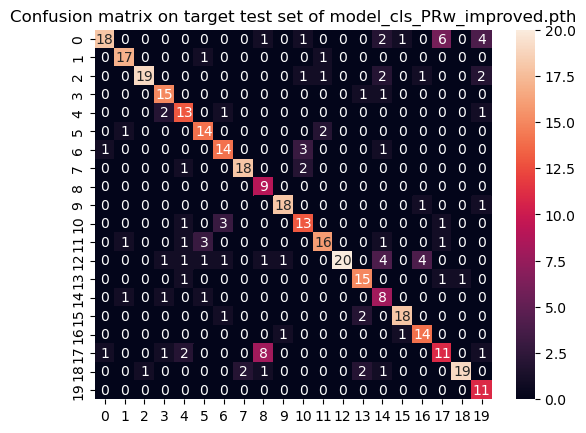

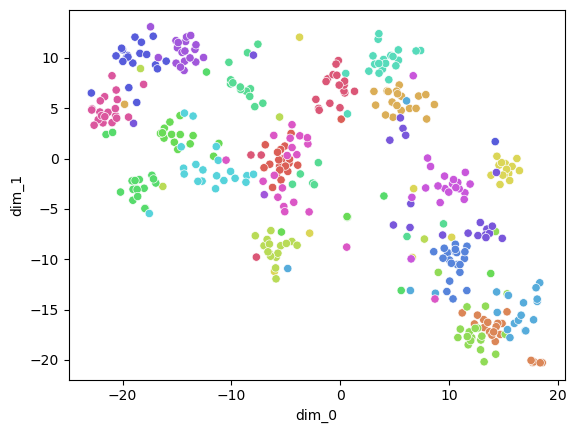

In [ ]:
trainer.visualize_cnf_tSNE("model_cls_PRw_improved.pth", dataset_real_valid)

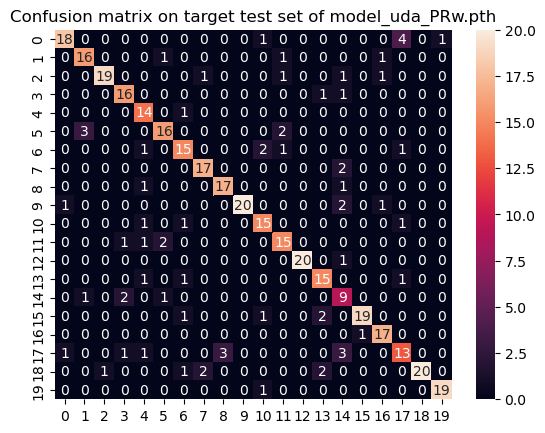

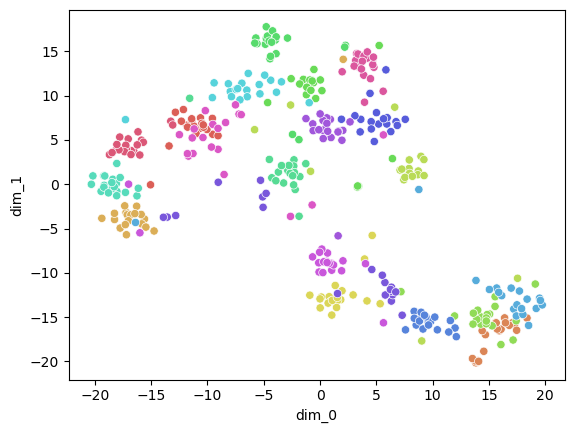

In [ ]:
trainer.visualize_cnf_tSNE("model_uda_PRw.pth", dataset_real_valid)

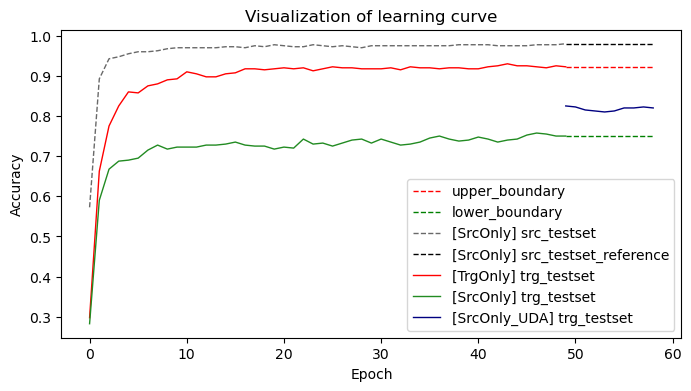

Accuracy on the target test set:

 Source only (selected)  Source only (max)  Applied UDA  Target only
                   0.75             0.7575        0.825       0.9225


In [ ]:
visualize_uda("log_cls_PRw_improved.log", "log_uda_PRw.log", "log_cls_RwP_improved.log")

In [ ]:
target_classes[8], target_classes[17], target_classes[14]

('glasses', 'purse', 'network switch')

**Conclusion**
- As visualized, the result on target test set of **applied UDA (0.825)** have a high performance gap compared to both **selected source only** model and **maximum possible accuracy** fron supervised source training **(0.75 and 0.7575)**.
- The model greatly improve the confusion between class `glasses` (index_8) and class `purse` (index 17), while the result on class `network_switch` have less improvement.

#### Real World to Product

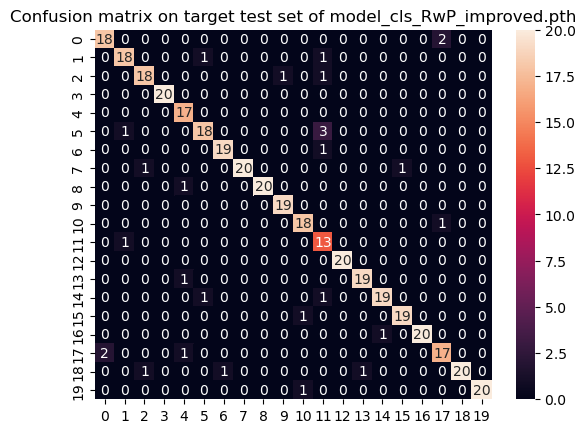

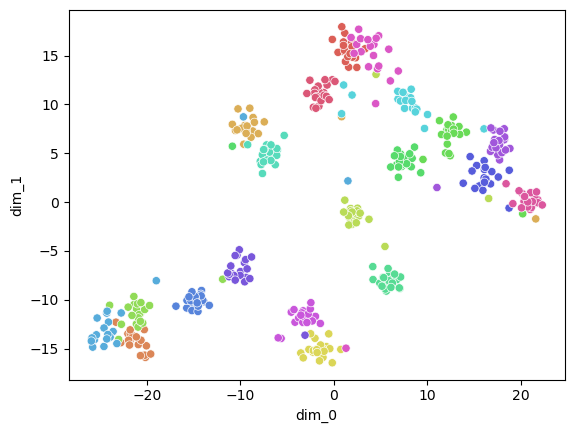

In [ ]:
trainer.visualize_cnf_tSNE("model_cls_RwP_improved.pth", dataset_real_valid)

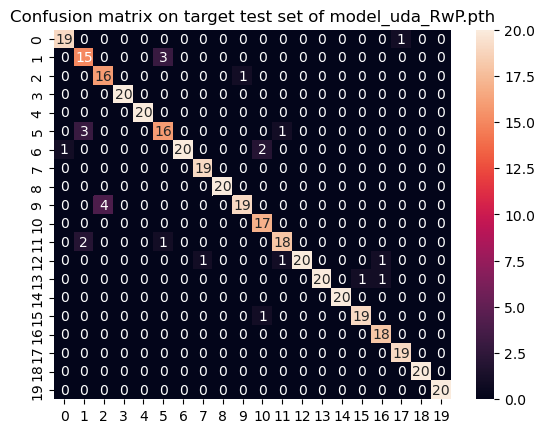

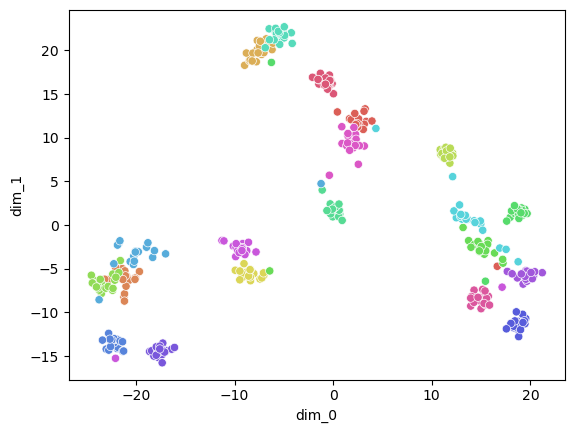

In [ ]:
trainer.visualize_cnf_tSNE("model_uda_RwP.pth", dataset_prod_valid)

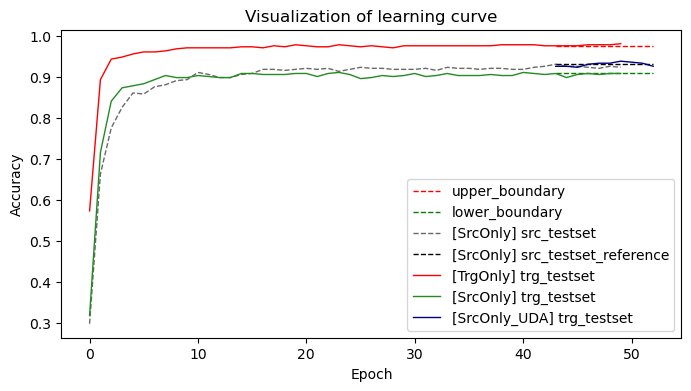

Accuracy on the target test set:

 Source only (selected)  Source only (max)  Applied UDA  Target only
                 0.9075               0.91       0.9375        0.975


In [ ]:
visualize_uda("log_cls_RwP_improved.log", "log_uda_RwP.log", "log_cls_PRw_improved.log")

In [ ]:
target_classes[11], target_classes[1], target_classes[2], target_classes[5]

('letter tray', 'bookcase', 'car jack', 'file cabinet')

**Conclusion**
- As visualized, the result on target test set of **applied UDA (0.9375)** have a high performance gap compared to both **selected source only** model and **maximum possible accuracy** fron supervised source training **(0.9075 and 0.91)**.
- the UDA_model have performance gain on class `letter tray`, while having small degradation in classes `bookcase`, `car jack` and `file cabinet`

# Final Conclusion

Based on our independent experiments of supervised learning:
- The **training on realworld trainset produce better result** compared to the training on product trainset. This might because of complex background in realworld trainset help model learns better discriminative features. 
- Compared to baseline model setting, **improved model setting provide better accuracy** on real_world testset and a small gap of performance on product testset.

Based on our independent experiments of unsupervised domain adaptation (UDA):
- Our UDA method shows consistent improvement in both training setting:
  - RW->P: **improved** from src_only model of **0.750** (max 0.757) to uda_model of **0.825**
  - P->RW: **improved** from src_only model of **0.907** (max 0.910) to uda_model of **0.937**
